In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data
import torchvision

In [2]:
from torchvision import transforms, datasets

data_dir = '../data/cifar/'

batch_size = 50

apply_transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 1 value per channel - 3 channels

trainset = datasets.CIFAR10(data_dir, train=True, transform=apply_transform, download=True)
testset = datasets.CIFAR10(data_dir, train=False, transform=apply_transform, download=True)
# trainset, valset = torch.utils.data.random_split(trainset, [int(0.9 * len(trainset)), int(0.1 * len(trainset))])

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

train_iter = iter(trainset)
image, label = next(train_iter)
image.shape, label, torch.min(image).item(), torch.max(image).item()
image = torchvision.utils.make_grid(image)

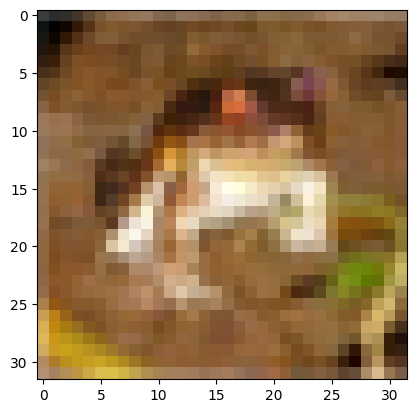

In [4]:
image = image / 2 + 0.5
npimg = image.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [5]:
len(trainset), len(testset)

(50000, 10000)

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
# valloader = torch.utils.data.DataLoader(valset, batch_size=50, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class CNNCifar(nn.Module):
    def __init__(self):
        super(CNNCifar, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 64, 2)
        # self.pool3 = nn.MaxPool2d(2, 2)
        # self.conv4 = nn.Conv2d(64, 64, 2)
        self.fc1 = nn.Linear(64 * 53 * 53, 500)
        self.drop1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(500, 100)
        self.drop2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(100, 10)  # 10 classes
        self.flatten = nn.Flatten()
        # (W - F + 2P)/S + 1
        # self.conv1 -> (32 - 5 + 2*0)/1 + 1 = 28 (final shape after first layer) 

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # x = self.pool2(F.relu(self.conv3(x)))
        x = F.relu(self.conv3(x))
        
        # x = x.view(-1, 64 * 4 * 4)
        x = self.flatten(x)
        
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        
        x = F.relu(self.fc2(x))
        # x = self.drop2(x)
        
        x = self.fc3(x)
        
        return x

In [8]:
net = CNNCifar()
net.to(device)

CNNCifar(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=179776, out_features=500, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (drop2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [9]:
# for i, data in enumerate(trainloader):
#     inputs, labels = data[0].to(device), data[1].to(device)
#     print(f'inputs: {inputs.shape}')
#     print(f'after network shape: {net(inputs).shape}')
#     break

In [10]:
num_params = 0
for x in net.parameters():
    num_params += len(torch.flatten(x))
print(f'Number of parameters: {num_params:,}')  # number of learnable parameters - shows how complex the network is

Number of parameters: 89,994,778


In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
# optimizer = optim.SGD(net.parameters(), lr=0.001)

In [12]:
def train_one_epoch():
    net.train(True)
    running_loss = 0.0
    running_accuracy = 0.0
    
    for batch_index, data in enumerate(trainloader):
        inputs = F.interpolate(data[0], size=(224, 224), mode='bilinear', align_corners=False).to(device)
        labels = data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_accuracy += correct / batch_size
        
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        # 
        # if running_accuracy >= 0.8:
        #     total = 0.0
        #     for batch_idx, (images, labels) in enumerate(testloader):
        #         images, labels = images.to(device), labels.to(device)
        #     
        #         # Inference
        #         outputs = net(images)
        #         batch_loss = criterion(outputs, labels)
        #         loss += batch_loss.item()
        #     
        #         # Prediction
        #         # _, pred_labels = torch.max(outputs, 1)
        #         # pred_labels = pred_labels.view(-1)
        #         correct += torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        #         total += len(labels)
        #         
        #         print('Test accuracy after train accuracy is at least 80%')
        #     
             
        
        if batch_index % batch_size == batch_size-1:  # print every 50 epochs
            avg_loss = running_loss / batch_size
            avg_accuracy = (running_accuracy / batch_size) * 100
            print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index + 1, avg_loss, avg_accuracy))
            running_loss = 0.0
            running_accuracy = 0.0

In [13]:
def validate_one_epoch():
    net.train(False)
    running_loss = 0.0
    running_accuracy = 0.0
    
    for i, data in enumerate(valloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        with torch.no_grad():
            outputs = net(inputs)
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / batch_size
            loss = criterion(outputs, labels)  # one number, the average batch loss
            running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        
    avg_loss = running_loss / len(valloader)
    avg_acc = (running_accuracy / len(valloader)) * 100
    
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss, avg_acc))
    print('-----------------------------------')

In [ ]:
num_epochs = 10

for epoch_index in range(num_epochs):
    print(f'Epoch {epoch_index + 1}\n')
    
    train_one_epoch()

    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(10)]
        n_class_samples = [0 for i in range(10)]
        for images, labels in testloader:
            images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False).to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            for i in range(5):
                label = labels[i]
                pred = predicted[i]
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1
    
        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network on the 10000 test images: {acc} %')
    # validate_one_epoch()

loss, correct, total = 0.0, 0.0, 0.0
for batch_idx, (images, labels) in enumerate(testloader):
    images, labels = images.to(device), labels.to(device)

    # Inference
    outputs = net(images)
    batch_loss = criterion(outputs, labels)
    loss += batch_loss.item()

    # Prediction
    # _, pred_labels = torch.max(outputs, 1)
    # pred_labels = pred_labels.view(-1)
    correct += torch.sum(labels == torch.argmax(outputs, dim=1)).item()
    total += len(labels)

print(f'Final accuracy: {100*correct/total}')

print('Finished Training')

# 74.4 -> 70% test acc with layers of size only 64, 180
# 86   -> 74% test acc with layers of size only 64, 280
# 92   -> 72% test acc with layers of size 64 first and then 128 rest, 280
# 92   -> 75% test acc with layers of size only 128, 280
# 89   -> 72% test acc with layers of size only 128, 280, no second dropout

Epoch 1
